## Project topic:

### "Deep learning for classification tasks on EEG data"

## Project members:

- Maxim Makarov
- Anuar Daurenov
- Dmitry Gribanov
- Alexey Morozov
- Aleksei Kalinkin

Everyone has contributed to the work equally

## Project goals:

Our goal is to try apply knowledge from DL course such as RNN, LSTM, GRU models to EEG datasets and try to play with it in order to enhance classification metrics. Also we will investigate current approaches in processing EEG data using NNs

## Install and import required libraries

In [1]:
import math
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import firwin, freqz, lfilter, welch
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

!pip install mne >> None
!pip install moabb >> None

import mne
import moabb
from mne.decoding import CSP
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery

import warnings

warnings.filterwarnings("ignore", message="warnEpochs")

## Seed all randomness for reproducibility

In [2]:
def seed_everything(seed=42):
    """Set random seed for reproducibility across multiple libraries."""
    random.seed(seed)  # Python built-in random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch

    # For CUDA (GPU operations)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # For sklearn if you're using it
    import sklearn
    sklearn.random.seed(seed)

    # For TensorFlow if you're using it
    import tensorflow as tf
    tf.random.set_seed(seed)

    # Set environment variable for additional libraries
    os.environ['PYTHONHASHSEED'] = str(seed)

# Usage
seed_everything(23052025)

The code below demonstrates how to filter synthetic signal with multiple frequency components (EEG-alike) using two different methods: frequency-domain filtering (FFT-based) and time-domain filtering (FIR convolution)

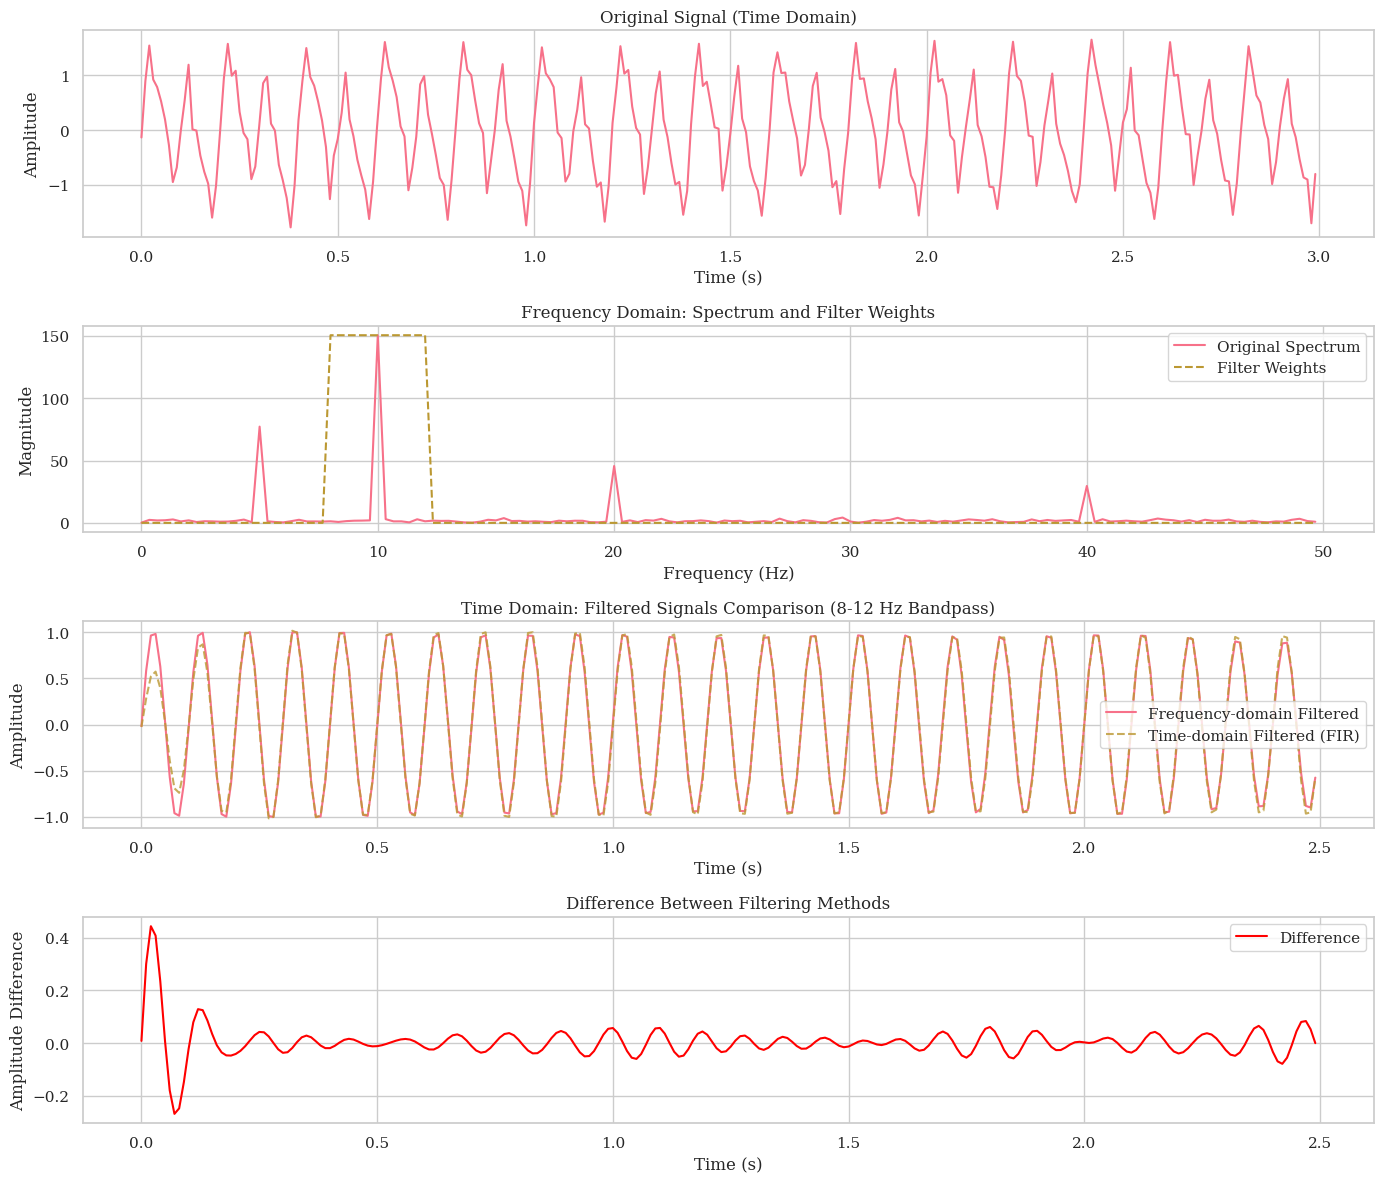

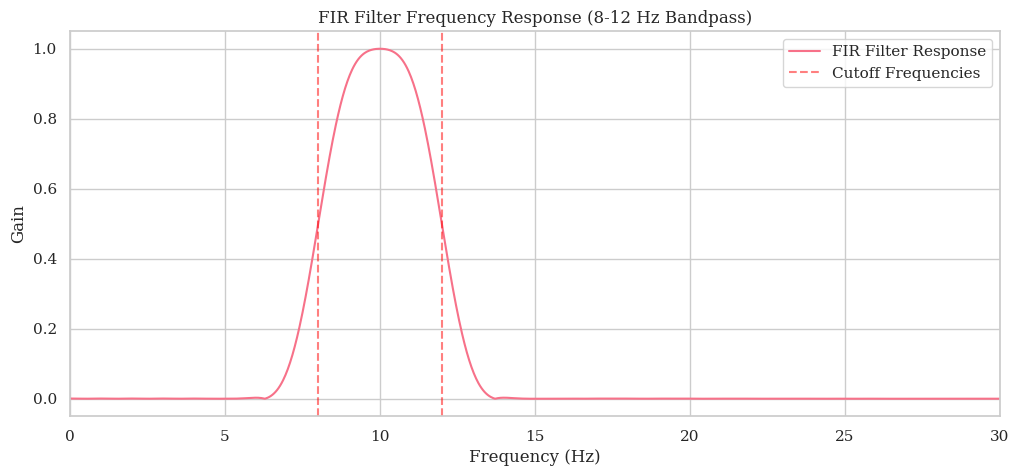

In [ ]:
# Parameters
sampling_rate = 100  # Hz
duration = 3.0  # seconds
n_samples = int(sampling_rate * duration)
time = np.linspace(0, duration, n_samples, endpoint=False)

# 1. Generate signal with multiple frequency components
def generate_signal(t):
    components = [
        0.5 * np.sin(2 * np.pi * 5.0 * t),   # 5 Hz
        1.0 * np.sin(2 * np.pi * 10.0 * t),   # 10 Hz (in our passband)
        0.3 * np.sin(2 * np.pi * 20.0 * t),   # 20 Hz
        0.2 * np.sin(2 * np.pi * 60.0 * t)    # 60 Hz noise
    ]
    return sum(components) + 0.1 * np.random.normal(size=len(t))

original_signal = generate_signal(time)

# 2. Frequency-domain filtering approach
signal_fft = fft(original_signal)
frequencies = fftfreq(n_samples, 1/sampling_rate)

# Create bandpass filter (8-12 Hz)
filter_mask = np.where((np.abs(frequencies) >= 8) & (np.abs(frequencies) <= 12), 1, 0)
filtered_fft = signal_fft * filter_mask
freq_filtered_signal = np.real(ifft(filtered_fft))

# 3. Time-domain filtering approach (proper convolution)
# Design a proper bandpass FIR filter
nyquist = 0.5 * sampling_rate
cutoff_low = 8.0 / nyquist
cutoff_high = 12.0 / nyquist
taps = 101  # Filter order (higher = sharper cutoff)
fir_coeff = firwin(taps, [cutoff_low, cutoff_high], pass_zero=False)

# Apply convolution (time-domain filtering)
time_filtered_signal = lfilter(fir_coeff, 1.0, original_signal)

# Delay compensation (FIR filters introduce delay)
delay = (taps - 1) // 2
time_filtered_signal = time_filtered_signal[delay:]
time_trimmed = time[:-delay]
freq_filtered_signal = freq_filtered_signal[delay:len(time_filtered_signal)+delay]

# 4. Plotting
plt.figure(figsize=(14, 12))

# Plot 0: Original signal
plt.subplot(4, 1, 1)
plt.plot(time, original_signal)
plt.title('Original Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

# Plot 1: Frequency domain operations
plt.subplot(4, 1, 2)
plt.plot(frequencies[:n_samples//2], np.abs(signal_fft[:n_samples//2]), label='Original Spectrum')
plt.plot(frequencies[:n_samples//2], filter_mask[:n_samples//2] * np.max(np.abs(signal_fft)),
         label='Filter Weights', linestyle='--')
plt.title('Frequency Domain: Spectrum and Filter Weights')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

# Plot 2: Time-domain results comparison
plt.subplot(4, 1, 3)
plt.plot(time_trimmed, freq_filtered_signal, label='Frequency-domain Filtered')
plt.plot(time_trimmed, time_filtered_signal, label='Time-domain Filtered (FIR)', linestyle='--', alpha=0.8)
plt.title('Time Domain: Filtered Signals Comparison (8-12 Hz Bandpass)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot 3: Difference between methods
plt.subplot(4, 1, 4)
difference = freq_filtered_signal - time_filtered_signal
plt.plot(time_trimmed, difference, label='Difference', color='red')
plt.title('Difference Between Filtering Methods')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude Difference')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional plot: FIR filter frequency response
plt.figure(figsize=(12, 5))
w, h = freqz(fir_coeff, worN=2000, fs=sampling_rate)
plt.plot(w, np.abs(h), label='FIR Filter Response')
plt.axvline(8, color='red', linestyle='--', alpha=0.5, label='Cutoff Frequencies')
plt.axvline(12, color='red', linestyle='--', alpha=0.5)
plt.title('FIR Filter Frequency Response (8-12 Hz Bandpass)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.xlim(0, 30)  # Zoom in to relevant frequencies
plt.legend()
plt.grid(True)
plt.show()

## Load data

First we use BNCI2014_001 dataset which is a publicly available EEG dataset designed for Brain-Computer Interface (BCI) research, particularly focusing on motor imagery tasks

Description: 22 EEG channels (0.5-100Hz; notch filtered), 3 EOG channels, 250Hz sampling rate, 4 classes, 9 subjects

More info about dataset [here](https://www.bbci.de/competition/iv/)

In [45]:
dataset = BNCI2014_001()
print(dataset.subject_list)
dataset.subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [46]:
paradigm = LeftRightImagery(resample=50) # Resample from 250 to 50Hz for fast training

In [47]:
X, labels, meta = paradigm.get_data(dataset=dataset) #, subjects=list(range(1, 10)))
y = (labels == 'right_hand').astype(int)

We're gonna deal with binary classification task

In [48]:
set(labels)

{'left_hand', 'right_hand'}

In [50]:
print(f'Size of EEG data: {X.shape}')
print(f'Size of labels: {y.shape}')
print(f'Size of metadata: {meta.shape}')

Size of EEG data: (2592, 22, 200)
Size of labels: (2592,)
Size of metadata: (2592, 3)


Split data into training and test subsets based on whether the session name ends with "test" or not

In [51]:
test_mask = meta['session'].str.endswith('test', na=False).to_numpy()
X_test, y_test = X[test_mask], y[test_mask]
X_train, y_train = X[~test_mask], y[~test_mask]
print(f'Train sizes: X {X_train.shape}, y {y_train.shape}')
print(f'Test sizes: X {X_test.shape}, y {y_test.shape}')

Train sizes: X (1296, 22, 200), y (1296,)
Test sizes: X (1296, 22, 200), y (1296,)


Let us try the simplest aprroaches

## Logistic Regression

In [ ]:
clf = LogisticRegression()
clf.fit(np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2])), y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
predict_test = clf.predict_proba(np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2])))

In [ ]:
predict_test.shape

(1296, 2)

In [ ]:
def print_metrics(y_true, y_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    roc_auc = metrics.roc_auc_score(y_true, y_score)
    y_predict = (y_score >= 0.5).astype(int)
    balanced_accuracy = metrics.balanced_accuracy_score(y_true, y_predict)
    accuracy = metrics.accuracy_score(y_true, y_predict)
    f1_score = metrics.f1_score(y_true, y_predict)
    precision = metrics.precision_score(y_true, y_predict)
    recall = metrics.recall_score(y_true, y_predict)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='dashed')
    plt.title(f'ROC AUC: {roc_auc}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print(f'Accuracy: {accuracy}')
    print(f'Balanced accuracy: {balanced_accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 score: {f1_score}')
    return fpr, tpr, roc_auc, accuracy, balanced_accuracy, precision, recall, f1_score

In [ ]:
all_metrics = {
    'Model': [], 'ROC AUC': [], 'Accuracy': [], 'Balanced Accuracy': [],
    'Precision': [], 'Recall': [], 'F1 score': []
}
roc_curves = {}

Logistic Regression


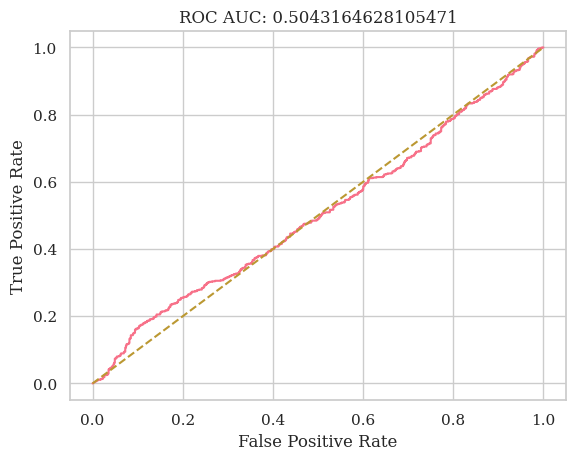

Accuracy: 0.5
Balanced accuracy: 0.5
Precision: 0.5
Recall: 0.47530864197530864
F1 score: 0.4873417721518987


In [ ]:
print('Logistic Regression')
fpr, tpr, roc_auc, accuracy, balanced_accuracy, precision, recall, f1_score = print_metrics(y_true=y_test, y_score=predict_test[:, 1])
all_metrics['Model'].append('Logistic Regression')
all_metrics['ROC AUC'].append(roc_auc)
all_metrics['Accuracy'].append(accuracy)
all_metrics['Balanced Accuracy'].append(balanced_accuracy)
all_metrics['Precision'].append(precision)
all_metrics['Recall'].append(recall)
all_metrics['F1 score'].append(f1_score)
roc_curves['Logistic Regression'] = {'fpr': fpr, 'tpr': tpr}

In [ ]:
metrics_df = pd.DataFrame(all_metrics)

metrics_df

,Model,ROC AUC,Accuracy,Balanced Accuracy,Precision,Recall,F1 score
0,Logistic Regression,0.504316,0.5,0.5,0.5,0.475309,0.487342


## Logistic Regression as a simple Neural Network

In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        assert self.X.size(0) == self.y.size(0), (self.X.size(), self.y.size())

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return self.X.size(0)

from sklearn.metrics import accuracy_score

def train_one_epoch(epoch_index, model, training_loader, optimizer, loss_fn):
    running_loss = 0.
    all_labels = []
    all_preds = []

    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Collect predictions and labels for accuracy
        preds = (outputs.squeeze() > 0.5).float()
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = running_loss / len(training_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy


def train_model(model, X, y, n_epochs):
    model.train()
    dataset = SimpleDataset(X=X, y=y)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    training_loader = DataLoader(dataset, batch_size=16)
    progress_bar = tqdm(range(n_epochs), total=n_epochs, desc=f'Training model')

    history = {'loss': [], 'accuracy': []}

    for epoch in progress_bar:
        avg_loss, accuracy = train_one_epoch(
            epoch_index=epoch, model=model, training_loader=training_loader,
            optimizer=optimizer, loss_fn=loss_fn
        )

        history['loss'].append(avg_loss)
        history['accuracy'].append(accuracy)

        progress_bar.set_postfix({'epoch_loss': f'{avg_loss:.4f}', 'accuracy': f'{accuracy:.4f}'})

    return history

def plot_loss_and_accuracy(history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'])
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['accuracy'])
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
model = nn.Sequential(
    nn.Linear(X_test.shape[1] * X_test.shape[2], 1),
    nn.Sigmoid()
)

Training model:   0%|          | 0/100 [00:00<?, ?it/s]

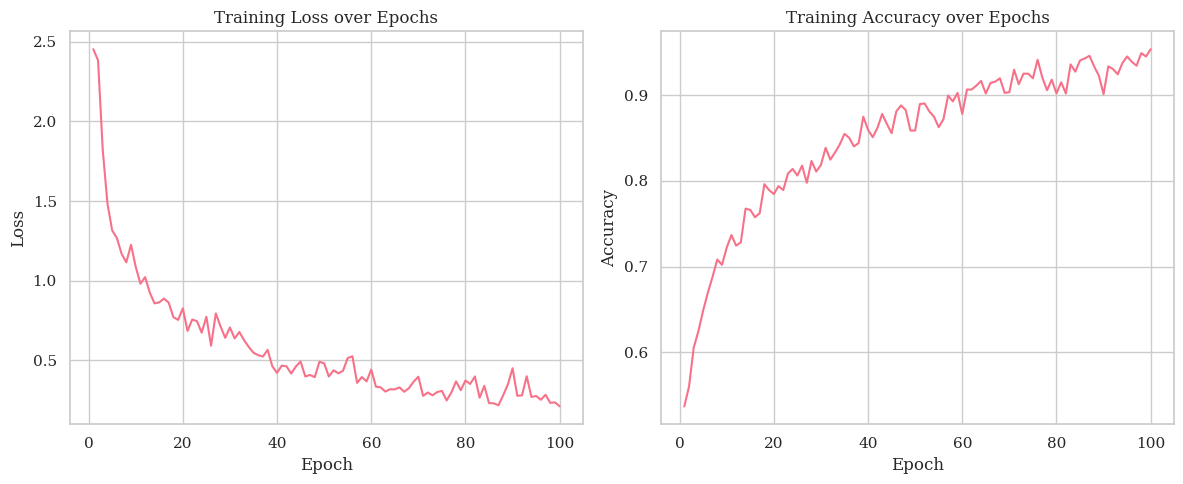

In [ ]:
history = train_model(model=model, X=np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2])), y=y_train, n_epochs=100)
plot_loss_and_accuracy(history)

Logistic Regression via Linear Layer


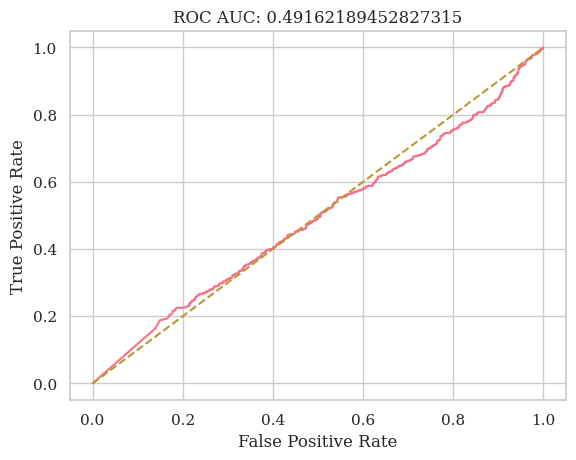

Accuracy: 0.4984567901234568
Balanced accuracy: 0.4984567901234568
Precision: 0.49838187702265374
Recall: 0.47530864197530864
F1 score: 0.48657187993680884


In [ ]:
print('Logistic Regression via Linear Layer')
model.eval()
predict_test = model(
    torch.from_numpy(
        np.reshape(
            X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]
                     )
            )
        ).float()
    )
fpr, tpr, roc_auc, accuracy, balanced_accuracy, precision, recall, f1_score = print_metrics(y_true=y_test, y_score=predict_test.detach().cpu().numpy())
all_metrics['Model'].append('Logistic Regression via Linear Layer')
all_metrics['ROC AUC'].append(roc_auc)
all_metrics['Accuracy'].append(accuracy)
all_metrics['Balanced Accuracy'].append(balanced_accuracy)
all_metrics['Precision'].append(precision)
all_metrics['Recall'].append(recall)
all_metrics['F1 score'].append(f1_score)
roc_curves['Logistic Regression via Linear Layer'] = {'fpr': fpr, 'tpr': tpr}

In [ ]:
metrics_df = pd.DataFrame(all_metrics)

metrics_df

,Model,ROC AUC,Accuracy,Balanced Accuracy,Precision,Recall,F1 score
0,Logistic Regression,0.504316,0.500000,0.500000,0.500000,0.475309,0.487342
1,Logistic Regression via Linear Layer,0.491622,0.498457,0.498457,0.498382,0.475309,0.486572


## Multi-layer Perceptron

In [ ]:
model = nn.Sequential(
    nn.Linear(X_test.shape[1] * X_test.shape[2], 20),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(20, 1),
    nn.Sigmoid()
)

Training model:   0%|          | 0/100 [00:00<?, ?it/s]

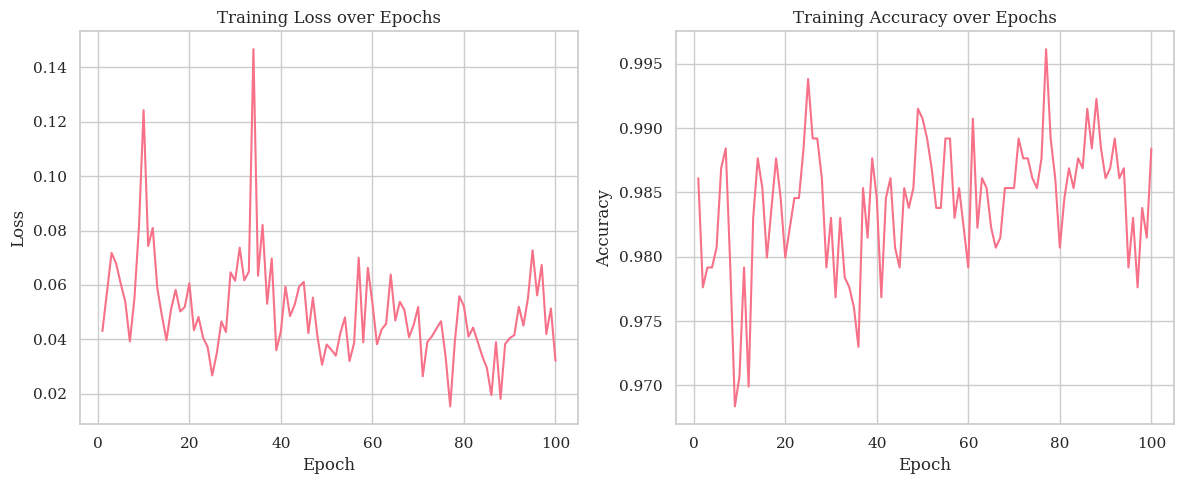

In [ ]:
history = train_model(model=model, X=np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2])), y=y_train, n_epochs=100)
plot_loss_and_accuracy(history)

Multi-layer Perceptron (MLP)


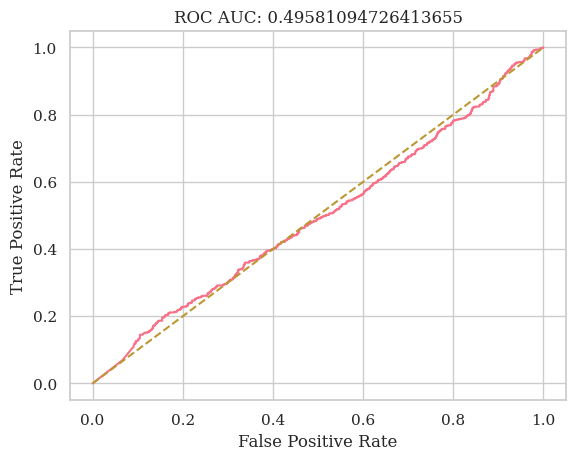

Accuracy: 0.49074074074074076
Balanced accuracy: 0.49074074074074076
Precision: 0.49101796407185627
Recall: 0.5061728395061729
F1 score: 0.49848024316109424


In [ ]:
print('Multi-layer Perceptron (MLP)')
model.eval()
predict_test = model(
    torch.from_numpy(
        np.reshape(
            X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]
                     )
            )
        ).float()
    )
fpr, tpr, roc_auc, accuracy, balanced_accuracy, precision, recall, f1_score = print_metrics(y_true=y_test, y_score=predict_test.detach().cpu().numpy())
all_metrics['Model'].append('Multi-layer Perceptron (MLP)')
all_metrics['ROC AUC'].append(roc_auc)
all_metrics['Accuracy'].append(accuracy)
all_metrics['Balanced Accuracy'].append(balanced_accuracy)
all_metrics['Precision'].append(precision)
all_metrics['Recall'].append(recall)
all_metrics['F1 score'].append(f1_score)
roc_curves['Multi-layer Perceptron (MLP)'] = {'fpr': fpr, 'tpr': tpr}

In [ ]:
metrics_df = pd.DataFrame(all_metrics)

metrics_df

,Model,ROC AUC,Accuracy,Balanced Accuracy,Precision,Recall,F1 score
0,Logistic Regression,0.504316,0.500000,0.500000,0.500000,0.475309,0.487342
1,Logistic Regression via Linear Layer,0.491622,0.498457,0.498457,0.498382,0.475309,0.486572
2,Multi-layer Perceptron (MLP),0.495811,0.490741,0.490741,0.491018,0.506173,0.498480


## Pointwise convolution model

In [53]:
model = nn.Sequential(
    nn.Conv1d(in_channels=X_test.shape[1], out_channels=10, kernel_size=1, bias=False),
    nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(X_test.shape[2] * 10, 1),
    nn.Sigmoid()
)

Training model:   0%|          | 0/100 [00:00<?, ?it/s]

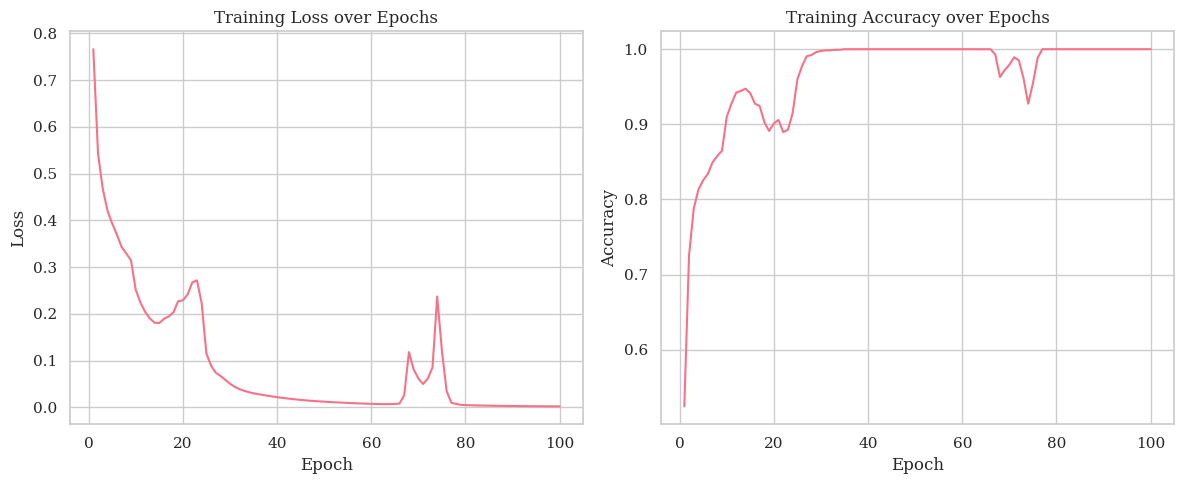

In [ ]:
history = train_model(model=model, X=X_train, y=y_train, n_epochs=100)
plot_loss_and_accuracy(history)

Pointwise convolution model


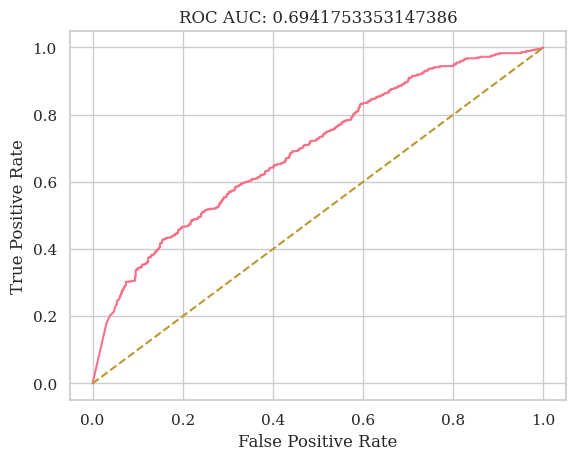

Accuracy: 0.6226851851851852
Balanced accuracy: 0.6226851851851851
Precision: 0.6202723146747352
Recall: 0.6327160493827161
F1 score: 0.6264323911382735


In [ ]:
print('Pointwise convolution model')
model.eval()
predict_test = model(torch.from_numpy(X_test).float())
fpr, tpr, roc_auc, accuracy, balanced_accuracy, precision, recall, f1_score = print_metrics(y_true=y_test, y_score=predict_test.detach().cpu().numpy())
all_metrics['Model'].append('Pointwise convolution model')
all_metrics['ROC AUC'].append(roc_auc)
all_metrics['Accuracy'].append(accuracy)
all_metrics['Balanced Accuracy'].append(balanced_accuracy)
all_metrics['Precision'].append(precision)
all_metrics['Recall'].append(recall)
all_metrics['F1 score'].append(f1_score)
roc_curves['Pointwise convolution model'] = {'fpr': fpr, 'tpr': tpr}

In [ ]:
metrics_df = pd.DataFrame(all_metrics)

metrics_df

,Model,ROC AUC,Accuracy,Balanced Accuracy,Precision,Recall,F1 score
0,Logistic Regression,0.504316,0.500000,0.500000,0.500000,0.475309,0.487342
1,Logistic Regression via Linear Layer,0.491622,0.498457,0.498457,0.498382,0.475309,0.486572
2,Multi-layer Perceptron (MLP),0.495811,0.490741,0.490741,0.491018,0.506173,0.498480
3,Pointwise convolution model,0.694175,0.622685,0.622685,0.620272,0.632716,0.626432


## Depthwise convolution model

In [52]:
model = nn.Sequential(
    nn.Conv1d(in_channels=X_test.shape[1], out_channels=X_test.shape[1], kernel_size=51, groups=X_test.shape[1], bias=False),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Flatten(start_dim=1),
    nn.Linear(X_test.shape[1] * (X_test.shape[2] - 51 + 1), 1),
    nn.Sigmoid()
)

Training model:   0%|          | 0/1000 [00:00<?, ?it/s]

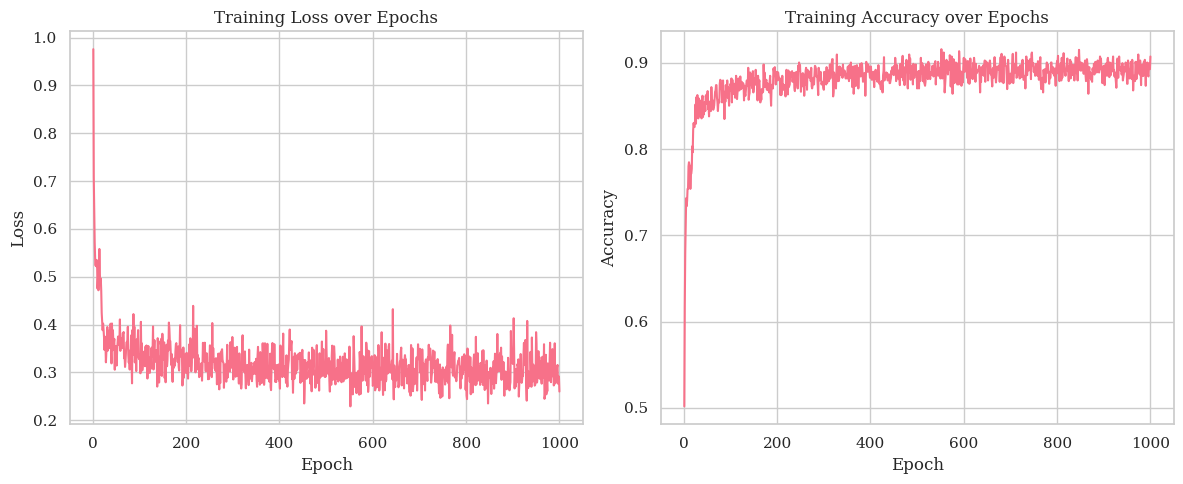

In [ ]:
history = train_model(model=model, X=X_train, y=y_train, n_epochs=1000)
plot_loss_and_accuracy(history)

Depthwise convolution model


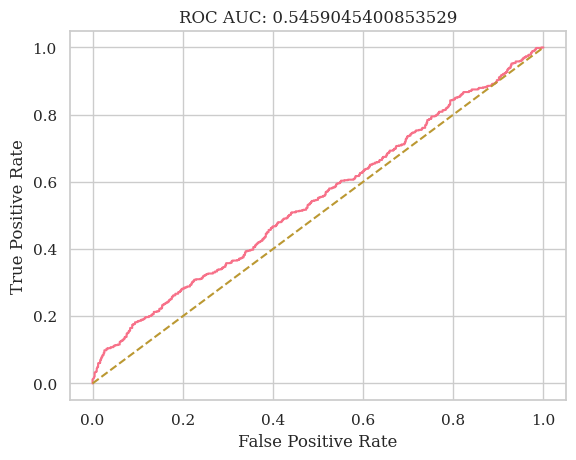

Accuracy: 0.533179012345679
Balanced accuracy: 0.533179012345679
Precision: 0.5391621129326047
Recall: 0.4567901234567901
F1 score: 0.49456975772765244


In [ ]:
print('Depthwise convolution model')
model.eval()
predict_test = model(torch.from_numpy(X_test).float())
fpr, tpr, roc_auc, accuracy, balanced_accuracy, precision, recall, f1_score = print_metrics(y_true=y_test, y_score=predict_test.detach().cpu().numpy())
all_metrics['Model'].append('Depthwise convolution model')
all_metrics['ROC AUC'].append(roc_auc)
all_metrics['Accuracy'].append(accuracy)
all_metrics['Balanced Accuracy'].append(balanced_accuracy)
all_metrics['Precision'].append(precision)
all_metrics['Recall'].append(recall)
all_metrics['F1 score'].append(f1_score)
roc_curves['Depthwise convolution model'] = {'fpr': fpr, 'tpr': tpr}

In [ ]:
metrics_df = pd.DataFrame(all_metrics)

metrics_df

,Model,ROC AUC,Accuracy,Balanced Accuracy,Precision,Recall,F1 score
0,Logistic Regression,0.504316,0.500000,0.500000,0.500000,0.475309,0.487342
1,Logistic Regression via Linear Layer,0.491622,0.498457,0.498457,0.498382,0.475309,0.486572
2,Multi-layer Perceptron (MLP),0.495811,0.490741,0.490741,0.491018,0.506173,0.498480
3,Pointwise convolution model,0.694175,0.622685,0.622685,0.620272,0.632716,0.626432
4,Depthwise convolution model,0.546598,0.529321,0.529321,0.551913,0.311728,0.398422
5,Depthwise convolution model,0.545905,0.533179,0.533179,0.539162,0.456790,0.494570


## Putting everything together

In [54]:
n_branches = 10
model = nn.Sequential(
    nn.Conv1d(in_channels=X_test.shape[1], out_channels=n_branches, kernel_size=1, bias=False),
    nn.Conv1d(in_channels=n_branches, out_channels=n_branches, kernel_size=51, groups=n_branches, bias=False),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(n_branches * (X_test.shape[2] - 51 + 1), 1),
    nn.Sigmoid()
)

Training model:   0%|          | 0/100 [00:00<?, ?it/s]

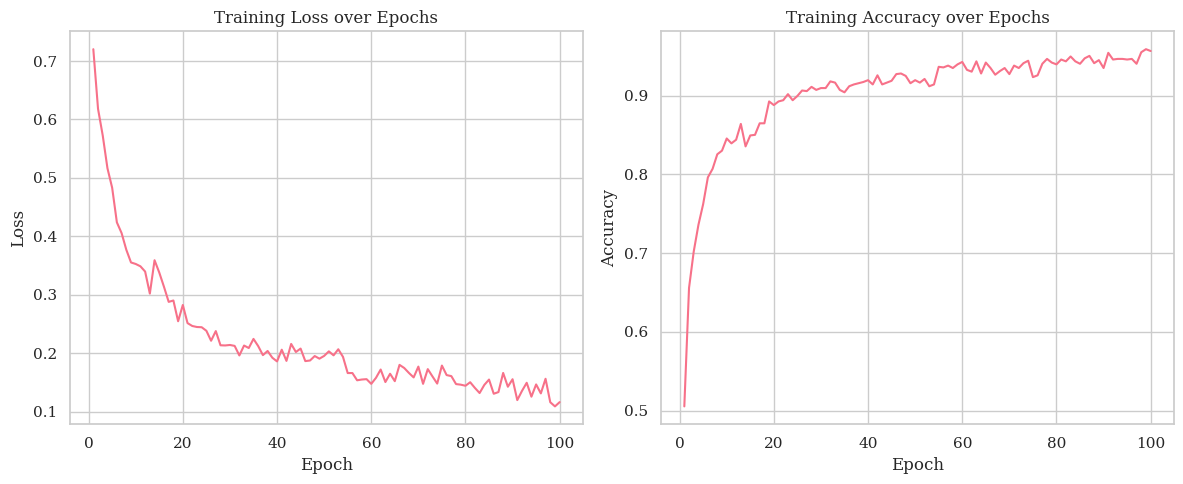

In [ ]:
history = train_model(model=model, X=X_train, y=y_train, n_epochs=100)
plot_loss_and_accuracy(history)

Combined model


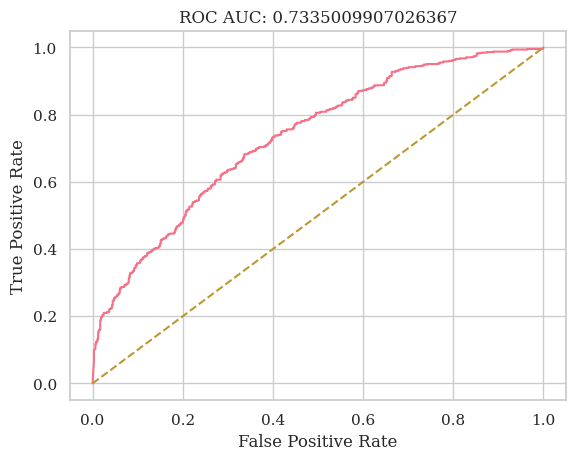

Accuracy: 0.6481481481481481
Balanced accuracy: 0.6481481481481481
Precision: 0.7096069868995634
Recall: 0.5015432098765432
F1 score: 0.5877034358047016


In [ ]:
print('Combined model')
model.eval()
predict_test = model(torch.from_numpy(X_test).float())
fpr, tpr, roc_auc, accuracy, balanced_accuracy, precision, recall, f1_score = print_metrics(y_true=y_test, y_score=predict_test.detach().cpu().numpy())
all_metrics['Model'].append('Combined model')
all_metrics['ROC AUC'].append(roc_auc)
all_metrics['Accuracy'].append(accuracy)
all_metrics['Balanced Accuracy'].append(balanced_accuracy)
all_metrics['Precision'].append(precision)
all_metrics['Recall'].append(recall)
all_metrics['F1 score'].append(f1_score)
roc_curves['Combined model'] = {'fpr': fpr, 'tpr': tpr}

## Compare all models

In [ ]:
all_metrics_df = pd.DataFrame(all_metrics)
all_metrics_df.style.background_gradient()

,Model,ROC AUC,Accuracy,Balanced Accuracy,Precision,Recall,F1 score
0,Logistic Regression,0.504316,0.500000,0.500000,0.500000,0.475309,0.487342
1,Logistic Regression via Linear Layer,0.491622,0.498457,0.498457,0.498382,0.475309,0.486572
2,Multi-layer Perceptron (MLP),0.495811,0.490741,0.490741,0.491018,0.506173,0.498480
3,Pointwise convolution model,0.694175,0.622685,0.622685,0.620272,0.632716,0.626432
4,Depthwise convolution model,0.546598,0.529321,0.529321,0.551913,0.311728,0.398422
5,Depthwise convolution model,0.545905,0.533179,0.533179,0.539162,0.456790,0.494570
6,Combined model,0.733501,0.648148,0.648148,0.709607,0.501543,0.587703


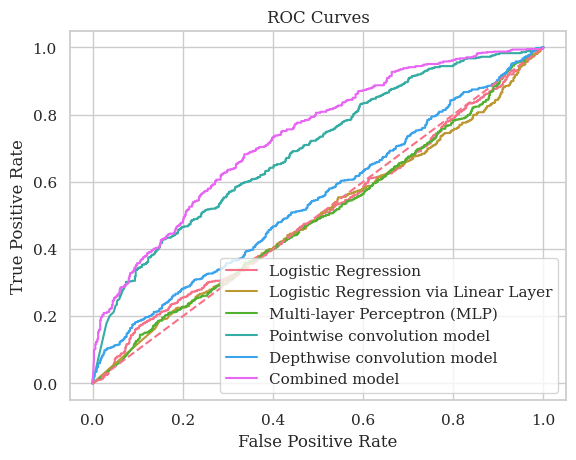

In [ ]:
plt.figure()
for model_name, metric_values in roc_curves.items():
    plt.plot(metric_values['fpr'], metric_values['tpr'], label=model_name)
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='dashed')
plt.legend()
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Interpreting patterns

In [ ]:
spatial_filters = model[0].weight.detach().cpu().squeeze(dim=-1)
print(f'Spatial filters size: {spatial_filters.shape}')
temporal_filters = model[1].weight.detach().cpu()
print(f'Trmporal filters size: {temporal_filters.shape}')

Spatial filters size: torch.Size([10, 22])
Trmporal filters size: torch.Size([10, 1, 51])


In [32]:
raw = dataset.get_data(subjects=[6])[6]['0train']['0']

In [33]:
raw

<RawArray | 26 x 96735 (386.9 s), ~19.2 MiB, data loaded>

In [34]:
# apply exactly the paradigm’s filtering + resampling
raw.load_data()   # make sure data are in memory
raw.filter(8,
           32,
           picks='eeg',
           fir_design='firwin')
raw.resample(paradigm.resample)      # e.g. 50 Hz sampling rate

<RawArray | 26 x 19347 (386.9 s), ~3.9 MiB, data loaded>

In [35]:
# pick only EEG channels
raw.pick_types(eeg=True)

<RawArray | 22 x 19347 (386.9 s), ~3.3 MiB, data loaded>

In [36]:
# now `raw` is your continuous, preprocessed data
print(raw)                # shows total duration, n_channels
eeg_data = raw.get_data()     # numpy array, shape = (n_channels, n_times)

<RawArray | 22 x 19347 (386.9 s), ~3.3 MiB, data loaded>


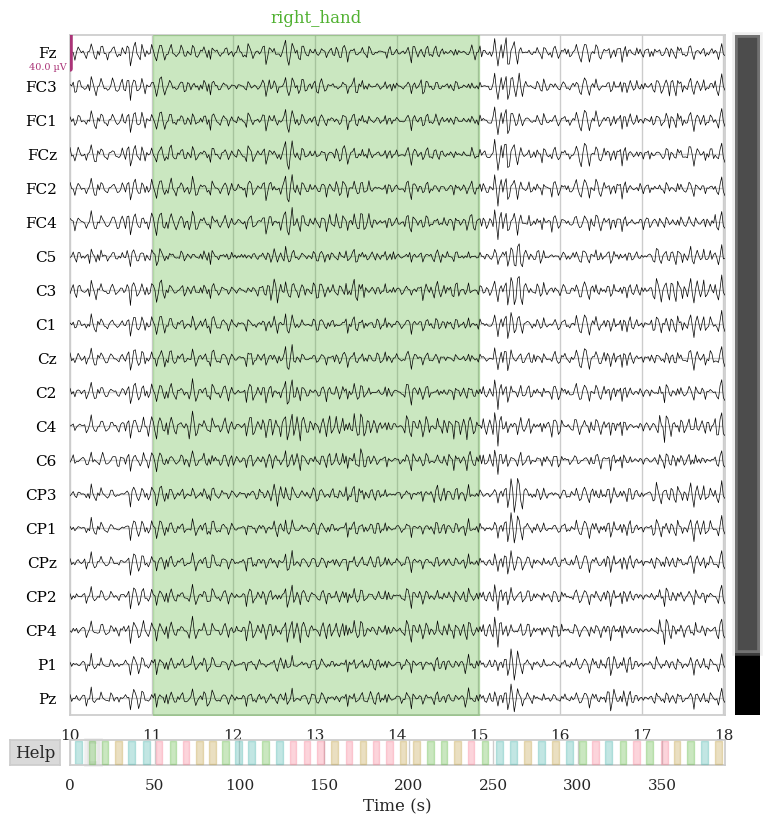

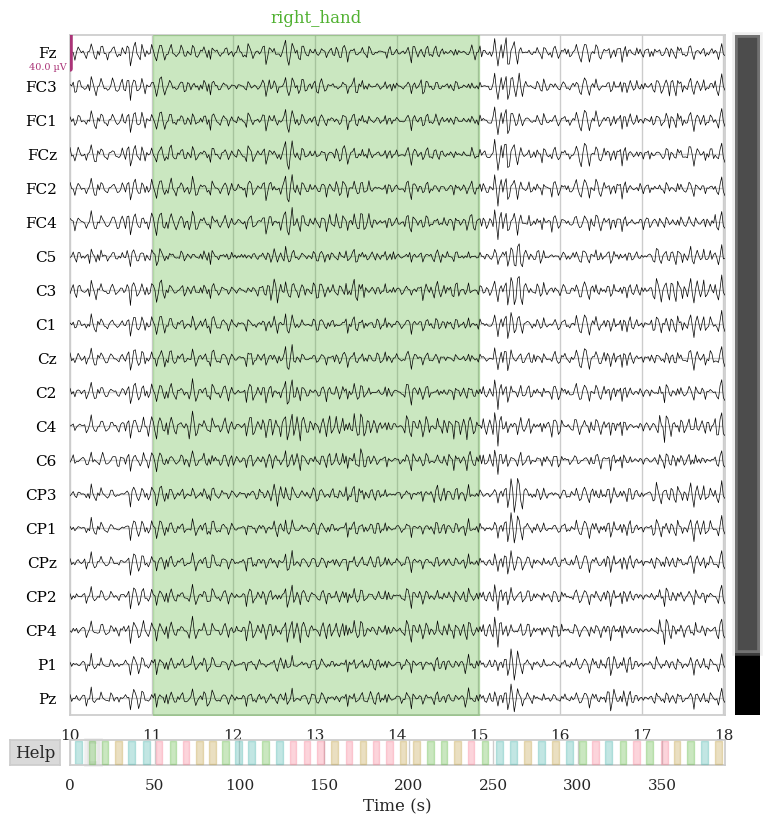

In [44]:
raw.plot(duration=8.0, start=10.0)

In [ ]:
eeg_channels = raw.info['ch_names']

In [ ]:
print(eeg_channels)

['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']


In [ ]:
def get_spatial_patterns(spatial_filters, temporal_filters, eeg_data):
    eeg_data = torch.from_numpy(eeg_data).float().unsqueeze(0)
    n_branches = spatial_filters.size(0)
    n_eeg_channels = eeg_data.size(1)

    spatial_patterns = []

    for branch_idx in range(n_branches):
        spatial_filter = spatial_filters[branch_idx, :]
        # spatial_filter: (n_eeg_channels, )
        temporal_filter = temporal_filters[branch_idx, :, :]
        # temporal_filter: (1, temporal_length)

        # Temporally filter data
        temporal_filter = temporal_filter.repeat(n_eeg_channels, 1, 1)
        # temporal_filter: (n_eeg_channels, 1, temporal_length)
        temporally_filtred_eeg = F.conv1d(eeg_data, temporal_filter, padding='same', groups=n_eeg_channels).squeeze(dim=0)
        # temporally_filtred_eeg: (n_eeg_channels, n_samples)

        # Calculate covariance matrix
        eeg_cov = torch.cov(temporally_filtred_eeg)
        # eeg_cov: (n_eeg_channels, n_eeg_channels)

        # Compute spatial patterns
        pattern = torch.matmul(eeg_cov, spatial_filter)
        # pattern: (n_eeg_channels, )

        spatial_patterns.append(pattern)

    spatial_patterns = torch.stack(spatial_patterns, dim=0)

    return spatial_patterns.detach().numpy()

In [ ]:
def plot_topographies(
        spatial_patterns: np.ndarray, eeg_channels: list[str], montage_name: str = 'standard_1020'
    ) -> plt.Figure:
    montage = mne.channels.make_standard_montage(montage_name)
    info = mne.create_info(eeg_channels, 1, ch_types='eeg')
    info.set_montage(montage)
    spatial_patterns = spatial_patterns.T

    evoked = mne.EvokedArray(
        data=spatial_patterns,
        info=info
    )

    n_patterns = spatial_patterns.shape[1]
    n_cols = n_patterns
    n_rows = n_patterns // n_cols
    if (n_patterns % n_cols) != 0:
        n_rows += 1

    fig = evoked.plot_topomap(
        times=np.arange(n_patterns) / evoked.info['sfreq'], ch_type='eeg', units='', scalings={'eeg': 1},
        time_format='', ncols=n_cols, nrows=n_rows, show=False
    )

    axes = fig.axes
    for idx in range(n_patterns):
        axes[idx].set_xlabel(f'Branch: {idx + 1}')

    fig.suptitle('Spatial patterns')

    plt.show()

In [ ]:
spatial_patterns = get_spatial_patterns(spatial_filters=spatial_filters, temporal_filters=temporal_filters, eeg_data=eeg_data)

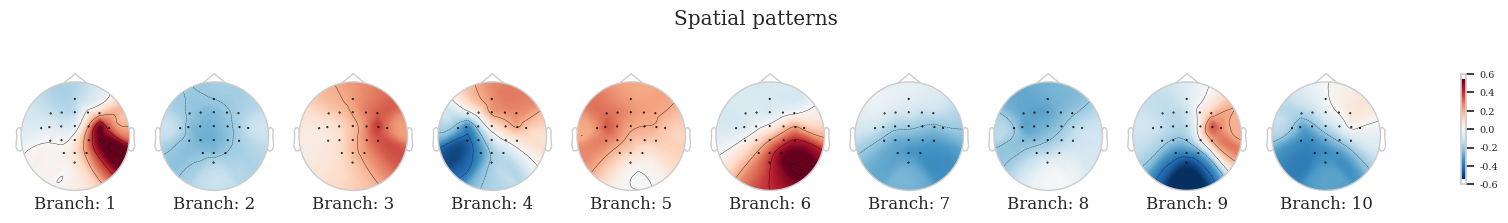

In [ ]:
plot_topographies(spatial_patterns=spatial_patterns / np.linalg.norm(spatial_patterns, axis=1, keepdims=True), eeg_channels=eeg_channels)

In [ ]:
def get_temporal_patterns(spatial_filters, temporal_filters, eeg_data, eeg_sampling_rate):
    eeg_data = torch.from_numpy(eeg_data).float().unsqueeze(0)
    n_branches = spatial_filters.size(0)
    n_eeg_channels = eeg_data.size(1)
    temporal_patterns = []

    for branch_idx in range(n_branches):
        spatial_filter = spatial_filters[branch_idx, :]
        # spatial_filter: (n_eeg_channels, )
        temporal_filter = temporal_filters[branch_idx, :, :].squeeze(dim=0)
        # temporal_filter: (temporal_length, )

        # Spatially filter data
        spatially_filtered_eeg = spatial_filter @ eeg_data
        # spatially_filtered_eeg: (n_samples, )

        fft_kernel = np.fft.rfft(temporal_filter.detach().numpy(), n=eeg_sampling_rate * 2)
        f_welch, Pxx_welch = welch(
            spatially_filtered_eeg.detach().numpy(), fs=eeg_sampling_rate,
            window='hann',
            nperseg=eeg_sampling_rate * 2,
            noverlap=eeg_sampling_rate,
            nfft=eeg_sampling_rate * 2,
            scaling='density'
        )
        assert Pxx_welch.shape[0] == 1, Pxx_welch.shape
        Pxx_welch = Pxx_welch[0, :]
        pattern = np.abs(fft_kernel * Pxx_welch)

        temporal_patterns.append(pattern)

    fft_freqs = np.fft.rfftfreq(n=eeg_sampling_rate * 2, d=1/eeg_sampling_rate)
    return fft_freqs, np.stack(temporal_patterns, axis=0)

In [ ]:
def plot_temporal_patterns(
        fft_freqs: np.ndarray, temporal_patterns: np.ndarray
    ):
    n_patterns = temporal_patterns.shape[0]

    fig, axes = plt.subplots(n_patterns, 1, figsize=(15, 30))

    for pattern_idx in range(n_patterns):

        ax = axes[pattern_idx]

        ax.plot(fft_freqs, temporal_patterns[pattern_idx])
        ax.set_title(f'Branch: {pattern_idx + 1}')
        if pattern_idx == (n_patterns - 1):
            ax.set_xlabel('Frequency (Hz)')

    fig.suptitle('Temporal patterns')

    plt.show()

In [ ]:
fft_freqs, temporal_patterns = get_temporal_patterns(spatial_filters=spatial_filters, temporal_filters=temporal_filters, eeg_data=eeg_data, eeg_sampling_rate=50)

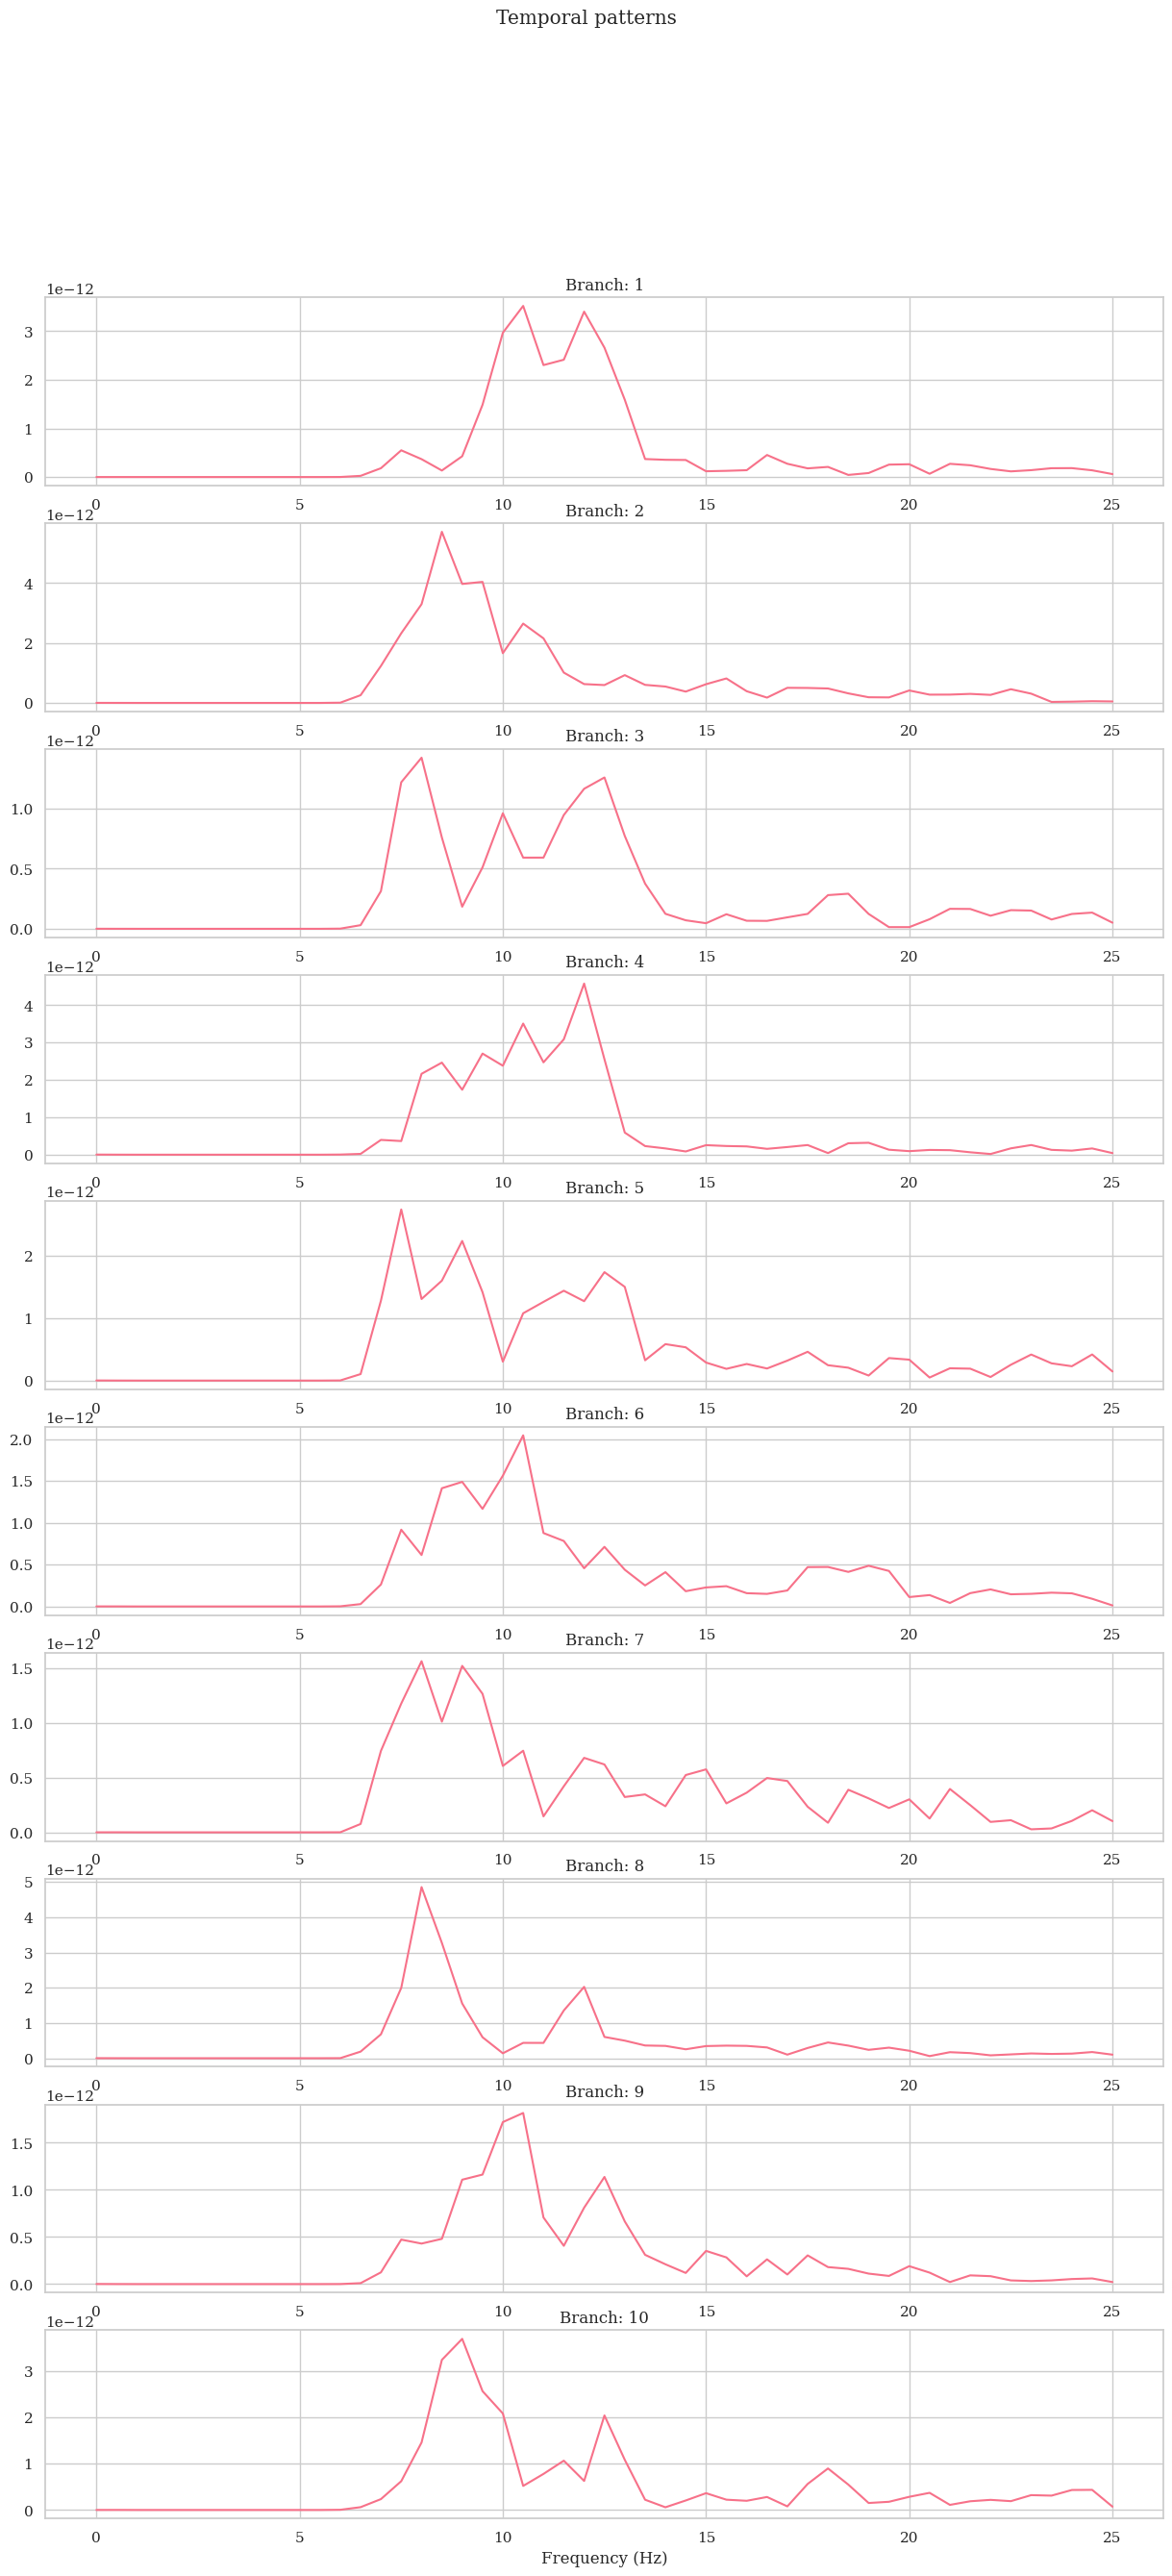

In [ ]:
plot_temporal_patterns(fft_freqs=fft_freqs, temporal_patterns=temporal_patterns)

## Using attention

In [ ]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (seq_len, batch_size, d_model)
        x = x + self.pe[:x.size(0), :]
        return x


class NeuralNetwork(nn.Module):
    def __init__(self, input_channels, n_branches, embedding_dim, num_heads, kernel_size=3):
        super(NeuralNetwork, self).__init__()

        # 1. Initial 1x1 convolution
        self.conv1x1_1 = nn.Conv1d(input_channels, n_branches, kernel_size=1, bias=False)

        # 2. Depthwise convolution
        self.depthwise = nn.Conv1d(
            n_branches,
            n_branches,
            kernel_size=kernel_size,
            padding=kernel_size//2,
            groups=n_branches
        )

        # 3. 1x1 convolution for embeddings
        self.conv1x1_2 = nn.Conv1d(n_branches, embedding_dim, kernel_size=1)

        # 4. Positional encoding
        self.pos_encoder = PositionalEncoding(embedding_dim)

        # 5. Multihead attention
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads)

        # 6. Linear layer for classification
        self.linear = nn.Linear(embedding_dim, 1)

        # 7. Sigmoid activation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: (batch_size, channels, time)

        # 1. Apply initial 1x1 convolution
        x = self.conv1x1_1(x)

        # 2. Apply depthwise convolution
        x = self.depthwise(x)

        # 3. Apply second 1x1 convolution
        x = self.conv1x1_2(x)

        # Prepare for attention - reshape to (seq_len, batch_size, embedding_dim)
        batch_size, channels, time = x.shape
        x = x.permute(2, 0, 1)  # (time, batch_size, channels)

        # 4. Add positional encoding
        x = self.pos_encoder(x)

        # 5. Apply multihead attention
        attn_output, _ = self.attention(x, x, x)

        # Global average pooling
        x = torch.mean(attn_output, dim=0)  # (batch_size, embedding_dim)

        # 6. Linear layer
        x = self.linear(x)

        # 7. Sigmoid activation
        x = self.sigmoid(x)

        return x.squeeze()


model = NeuralNetwork(input_channels=X_train.shape[1], n_branches=10, embedding_dim=32, num_heads=4, kernel_size=51)

Training model:   0%|          | 0/200 [00:00<?, ?it/s]

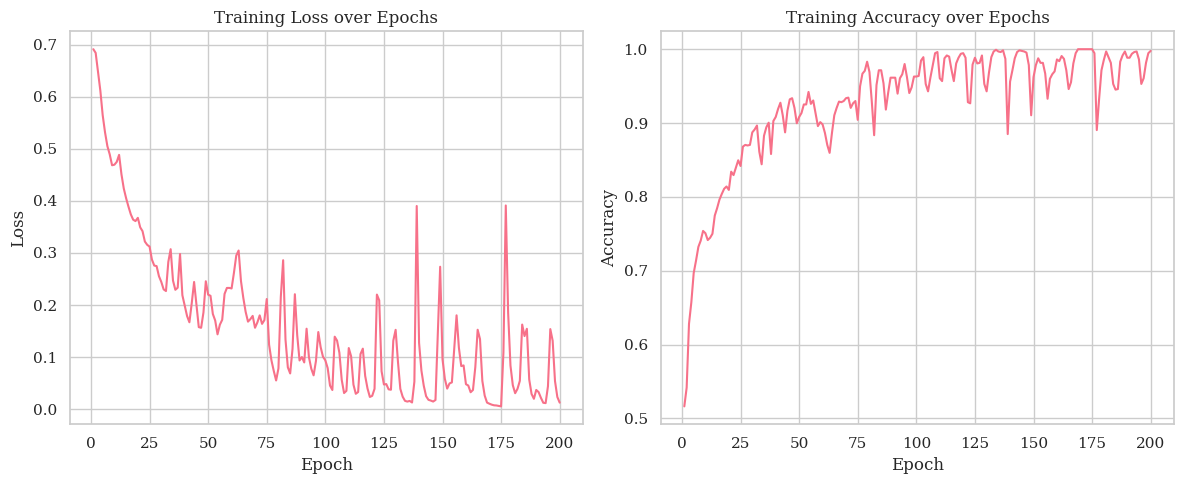

In [ ]:
history = train_model(model=model, X=X_train, y=y_train, n_epochs=200)
plot_loss_and_accuracy(history)

Multi-head attention model


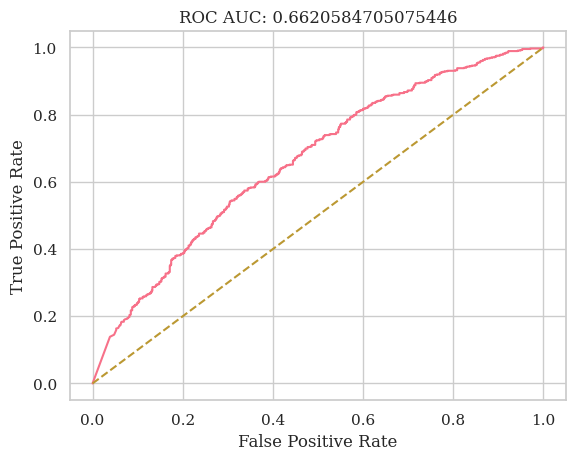

Accuracy: 0.6095679012345679
Balanced accuracy: 0.6095679012345679
Precision: 0.637065637065637
Recall: 0.5092592592592593
F1 score: 0.5660377358490566


In [ ]:
print('Multi-head attention model')
model.eval()
predict_test = model(torch.from_numpy(X_test).float())
fpr, tpr, roc_auc, accuracy, balanced_accuracy, precision, recall, f1_score = print_metrics(y_true=y_test, y_score=predict_test.detach().cpu().numpy())
all_metrics['Model'].append('Multi-head attention model')
all_metrics['ROC AUC'].append(roc_auc)
all_metrics['Accuracy'].append(accuracy)
all_metrics['Balanced Accuracy'].append(balanced_accuracy)
all_metrics['Precision'].append(precision)
all_metrics['Recall'].append(recall)
all_metrics['F1 score'].append(f1_score)
roc_curves['Multi-head attention model'] = {'fpr': fpr, 'tpr': tpr}

## Compare all models (again)

In [ ]:
all_metrics_df = pd.DataFrame(all_metrics)
all_metrics_df.style.background_gradient()

,Model,ROC AUC,Accuracy,Balanced Accuracy,Precision,Recall,F1 score
0,Logistic Regression,0.504316,0.500000,0.500000,0.500000,0.475309,0.487342
1,Logistic Regression via Linear Layer,0.491622,0.498457,0.498457,0.498382,0.475309,0.486572
2,Multi-layer Perceptron (MLP),0.495811,0.490741,0.490741,0.491018,0.506173,0.498480
3,Pointwise convolution model,0.694175,0.622685,0.622685,0.620272,0.632716,0.626432
4,Depthwise convolution model,0.546598,0.529321,0.529321,0.551913,0.311728,0.398422
5,Depthwise convolution model,0.545905,0.533179,0.533179,0.539162,0.456790,0.494570
6,Combined model,0.733501,0.648148,0.648148,0.709607,0.501543,0.587703
7,Multi-head attention model,0.662058,0.609568,0.609568,0.637066,0.509259,0.566038


Furher we may try applying these models on more complicated datasets of big-scale like `moabb.datasets.Stieger2021` (~350Gb)

In [26]:
from moabb.datasets import Stieger2021

dataset = Stieger2021()
print("Subjects in Stieger2021 dataset:", len(dataset.subject_list))

Subjects in Stieger2021 dataset: 62
